# Quantum Forecasting for Energy Demand
## The Goal

It's a simple goal, I want to beat AEMO at their own game! Their forecasting game. So let's start simply with a day ahead forecast. 

## Data Prep

I need 3 things:
1. AEMO's forecast for the day ahead
2. Historical Energy Demand - last year
3. Actuals over the forecasted period - e.g. the 1 day (retrospectively)

Luckily I've built a tool to be able to extract and aggregate these documents from NEMWeb : [#Link]


In [2]:
import sys
sys.path.append("/Users/gatsby.fitzgerald/Library/CloudStorage/OneDrive-Accenture/Development/QuantumPlayground")

from utils import load_s3_csv

s3_url="s3://nem-web-data/NEMWebScrape/ARCHIVE_Operational_Demand_Actual_HH/NEMWEB_ARCHIVE_Operational_Demand_Actual_HH_20251209170342.csv"

df = load_s3_csv(
    s3_url, storage_options={"anon": "true"}
)

df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)
df = df[~df["I"].isin(["C", "I"])].reset_index(drop=True)

df = df.loc[:, ~df.columns.duplicated(keep="last")]

print(df.head())

display(df.info())

0  I  ACTUAL  3 REGIONID    INTERVAL_DATETIME OPERATIONAL_DEMAND  \
0  D  ACTUAL  3     NSW1  2024/11/17 00:00:00               6972   
1  D  ACTUAL  3     QLD1  2024/11/17 00:00:00               6059   
2  D  ACTUAL  3      SA1  2024/11/17 00:00:00               1387   
3  D  ACTUAL  3     TAS1  2024/11/17 00:00:00               1103   
4  D  ACTUAL  3     VIC1  2024/11/17 00:00:00               4888   

0 OPERATIONAL_DEMAND_ADJUSTMENT WDR_ESTIMATE          LASTCHANGED  \
0                             0            0  2024/11/17 00:00:03   
1                             0            0  2024/11/17 00:00:03   
2                             0            0  2024/11/17 00:00:03   
3                             0            0  2024/11/17 00:00:03   
4                             0            0  2024/11/17 00:00:03   

0 PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20241117.zip -> PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_202411170000_20241117000004.zip  \
0  PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20241117.z..

None

## The Approach

As part of this experiment, we will do two things, firstly we will do a simple classical forecast using the Statsmodel library and time-series model -> SARIMA. This will give us a flavour of how forecasting works.

Note: Since we are relying on seasonality to drive the forecasting at this point, not exogenous factors like weather etc. Hence why we will be using good old SARIMA.

Then, we will progress onto the bit you are actually interested in, a quantum voyage into using Quantum Machine Learning, which is essentially a hybrid between Quantum Computing and Machine Learning. 

## Starting with a classical approach

Step 1. Cleaning the data
Step 2. Apply the model
Step 3. Evaluate

### Step 1. Cleaning the Data

In [3]:
import pandas as pd


df["INTERVAL_DATETIME"] = pd.to_datetime(df["INTERVAL_DATETIME"])
df["OPERATIONAL_DEMAND"] = pd.to_numeric(df["OPERATIONAL_DEMAND"], errors="coerce")

df = df.sort_values("INTERVAL_DATETIME").set_index("INTERVAL_DATETIME")
display(df)

,I,ACTUAL,3,REGIONID,OPERATIONAL_DEMAND,OPERATIONAL_DEMAND_ADJUSTMENT,WDR_ESTIMATE,LASTCHANGED,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20241117.zip -> PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_202411170000_20241117000004.zip,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_202411170000_20241117000004.CSV
INTERVAL_DATETIME,,,,,,,,,,
2024-11-17 00:00:00,D,ACTUAL,3,NSW1,6972,0,0,2024/11/17 00:00:03,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20241117.z...,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_2024111700...
2024-11-17 00:00:00,D,ACTUAL,3,QLD1,6059,0,0,2024/11/17 00:00:03,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20241117.z...,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_2024111700...
2024-11-17 00:00:00,D,ACTUAL,3,SA1,1387,0,0,2024/11/17 00:00:03,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20241117.z...,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_2024111700...
2024-11-17 00:00:00,D,ACTUAL,3,TAS1,1103,0,0,2024/11/17 00:00:03,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20241117.z...,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_2024111700...
2024-11-17 00:00:00,D,ACTUAL,3,VIC1,4888,0,0,2024/11/17 00:00:03,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20241117.z...,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_2024111700...
...,...,...,...,...,...,...,...,...,...,...
2025-04-05 23:30:00,D,ACTUAL,3,TAS1,1078,0,0,2025/04/05 23:30:01,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20250330.z...,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_2025040523...
2025-04-05 23:30:00,D,ACTUAL,3,NSW1,6847,0,0,2025/04/05 23:30:01,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20250330.z...,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_2025040523...
2025-04-05 23:30:00,D,ACTUAL,3,QLD1,6225,0,0,2025/04/05 23:30:01,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20250330.z...,PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_2025040523...


### Step 2. Apply the model

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


regions = df["REGIONID"].unique()
results = []


for i in regions:
    df_region = df[df["REGIONID"] == i].copy()

    series = df_region["OPERATIONAL_DEMAND"].asfreq("30min")


    steps = 48
    # Hold out the last 48 points as test
    train = series.iloc[:-steps]
    test = series.iloc[-steps:]

    # Refit on train only to avoid peeking
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 48),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)

    forecast = res.forecast(steps=steps).rename("forecast")

    results.append((i, test, forecast))


Step 3. Evaluate

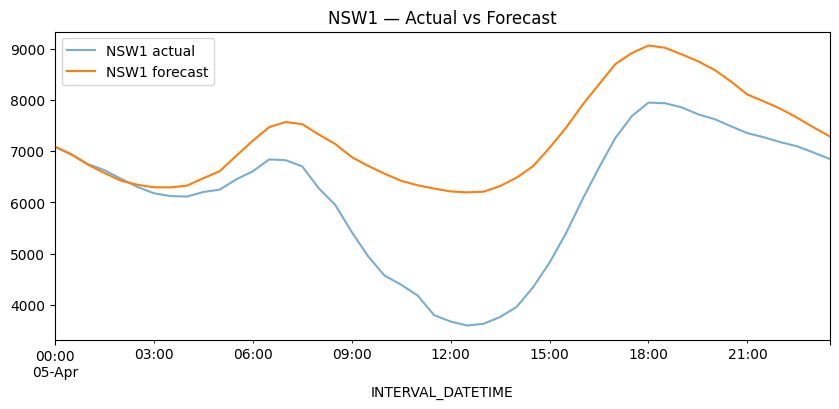

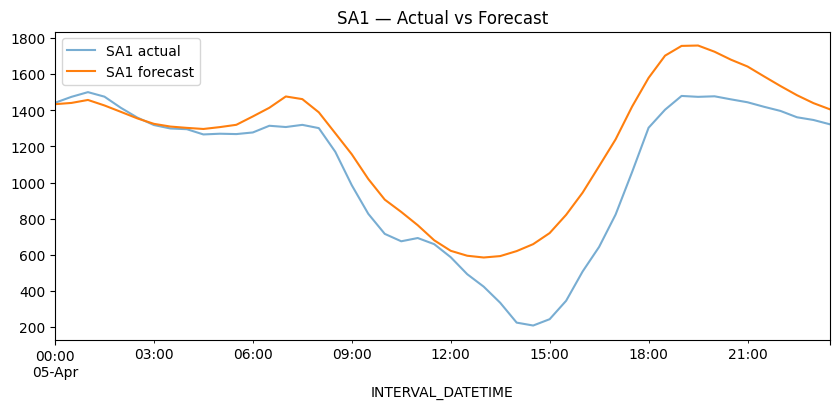

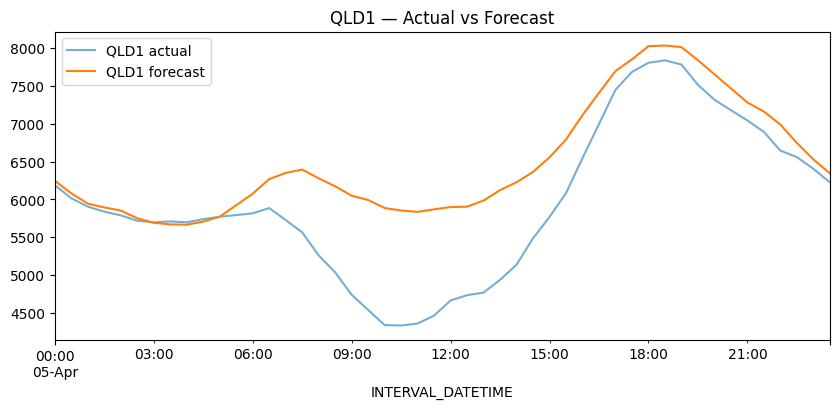

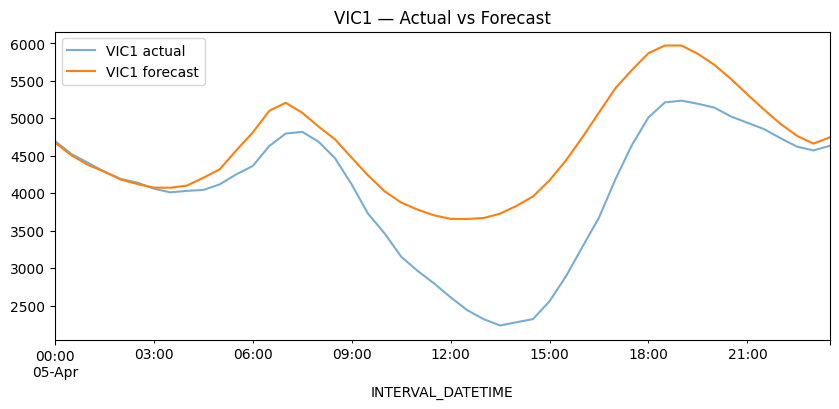

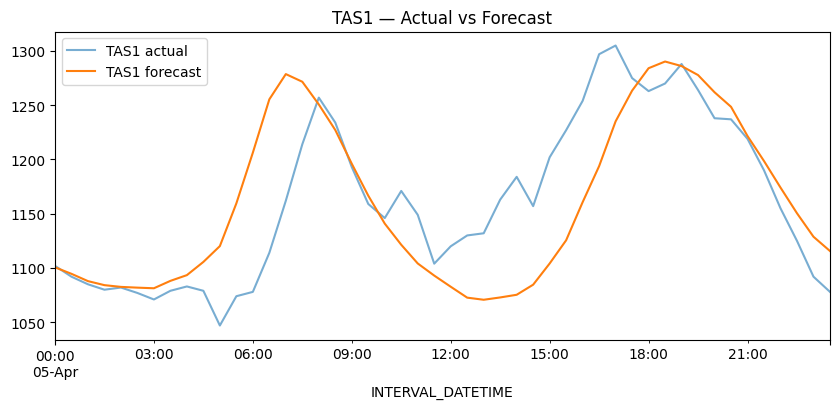

In [16]:
# ...existing code...
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from matplotlib import pyplot as plt

# results contains tuples: (region, test_series, forecast_series)
metrics_rows = []
lines = []

for region, test, forecast in results:
    # Align forecast to test index and build paired frame
    fc = forecast.rename("forecast").reindex(test.index)
    eval_df = pd.concat([test.rename("actual"), fc], axis=1).dropna()

    actual = eval_df["actual"]
    pred = eval_df["forecast"]

    # Metrics
    mae = mean_absolute_error(actual, pred)
    rmse = root_mean_squared_error(actual, pred)
    mape = (np.abs((actual - pred) / actual.replace(0, np.nan))).mean() * 100

    metrics_rows.append({"region": region, "MAE": mae, "RMSE": rmse, "MAPE": mape})

    # Store lines for plotting/saving
    lines.append(
        eval_df.assign(region=region)
    )

# Aggregate metrics and series
metrics_df = pd.DataFrame(metrics_rows).set_index("region").sort_index()
series_df = pd.concat(lines).sort_index()  # columns: actual, forecast, region

# Plot: overlay forecasts per region
ax = None
for region in series_df["region"].unique():
    sub = series_df[series_df["region"] == region]
    ax = sub["actual"].plot(figsize=(10,4), label=f"{region} actual", alpha=0.6)
    sub["forecast"].plot(ax=ax, label=f"{region} forecast")
    ax.set_title(f"{region} — Actual vs Forecast")
    ax.legend()
    plt.show()

## Time to start our quantum voyage

So in comparison to our classical approach...

